This is the smp file

In [1]:
# Import the connection function from the snowexsql library
from snowexsql.db import get_db

# This is what you will use for all of hackweek to access the db
db_name = 'snow:hackweek@52.32.183.144/snowex'

# Using the function get_db, we receive 2 ways to interact with the database
engine, session = get_db(db_name)
# Import the layer table which is where SMP data lives
from snowexsql.data import LayerData

# Import our convenient tool to convert to geopandas dataframes
from snowexsql.conversions import query_to_geopandas

# A little matplotlib biz if you want to plot multiple plots in a loop
import matplotlib.pyplot as plt 

# import geopandas lib to make a brand new GeoDataFrame to store your final results
import geopandas as gpd 

import pandas as pd
import numpy as np

Generate some data frames to store the data

In [2]:
final_df = gpd.GeoDataFrame(columns = ['siteID','med_force','geom','sum10','sum50'])
to_add_df = gpd.GeoDataFrame(columns = ['siteID','med_force','geom','sum10','sum50'])
#print(final_df)

Find some SMP filenames

In [3]:
site = '7C15'
engine_smp, session_smp = get_db(db_name)
q_smp = session_smp.query(LayerData).filter(LayerData.type == 'force').filter(LayerData.site_id.contains(site) )
df_smp = query_to_geopandas(q_smp, engine_smp)

q_pit=session_smp.query(LayerData).filter(LayerData.type == 'hand_hardness').filter(LayerData.site_id.contains(site) )
df_pit = query_to_geopandas(q_pit, engine_smp)

session_smp.close()

# # Plot SMP profile locations with colored by the time they were taken using upside down triangles
# ax = df_smp.plot(column='time', cmap='jet', marker='v', label='SMP', figsize=(5,5), markersize=100, edgecolor='black')

# ax.plot(df_pit.easting, df_pit.northing, color='black', marker='s', markersize=15, label='Pit ({})'.format(site))

# # Add important labels
# ax.set_xlabel('Easting [m]')
# ax.set_ylabel('Northing [m]')
# plt.suptitle('SMP Locations at Site {} Showing Acquisition Order'.format(site), fontsize=16)

# # Avoid using Scientific notation for coords.
# ax.ticklabel_format(style='plain', useOffset=False)
# ax.legend()
# # plt.tight_layout()
# plt.show()

In [4]:
# find closest SMP profile to the pit

# No profile is taken at the same time, so we grab all the unique times and sort them
times = sorted(df_smp['time'].unique())

nprofiles=len(times)

ids=np.empty(nprofiles)

p=0
for t in times:
    ind = df_smp['time'] == t
    data = df_smp.loc[ind].copy()
    ids[p]=data.iloc[0].id
    p+=1
    
i_dists=df_smp['id'].isin(ids)

df_smp_dists=df_smp.loc[i_dists]
df_smp_dists=df_smp_dists.assign(dists=-1)
df_smp_dists['dists']=np.sqrt((df_smp_dists['easting']-df_pit.iloc[0].easting)**2+(df_smp_dists['northing']-df_pit.iloc[0].northing)**2)

    
df_smp_dists.sort_values(by='dists')[['comments','dists']].head() #check out the list of profiles sorted by distance to pit

,comments,dists
21313,"fname = SNEX20_SMP_S06M0831_7C15_20200130.CSV,...",2.325973
16703,"fname = SNEX20_SMP_S06M0833_7C15_20200130.CSV,...",2.604038
9109,"fname = SNEX20_SMP_S06M0832_7C15_20200130.CSV,...",3.695795
1546,"fname = SNEX20_SMP_S06M0835_7C15_20200130.CSV,...",5.091385
24394,"fname = SNEX20_SMP_S06M0836_7C15_20200130.CSV,...",5.283580


Plot the raw data for one of the files

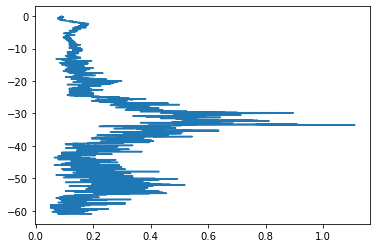

In [5]:
filenames = ['SNEX20_SMP_S06M0831_7C15_20200130.CSV']

for f in filenames:
    # Grab any layer data that has the file name in its comments
    qry = session.query(LayerData).filter(LayerData.comments.contains(f)).order_by('depth')

    # build a geopandas dataframe from the query
    df = query_to_geopandas(qry, engine)

    # Everything in the layers table is a string so we need to cast our value column as a float to calc stats on it
    df['value'] = df['value'].astype(float)

    # plot biz plot the profile vertically.
    fig, axes = plt.subplots(1)
    axes.plot(df['value'], df['depth'])

Manually input the snow surface and ground values

In [6]:
surface = 0
ground = -65

Find the median between the surface and ground, the sum of force measurements in the first 10 and 50 cm, plot the filtered data, and add data to the data frame

0.169
31.749000000000002
289.4200000000001
  siteID  med_force                            geom   sum10   sum50
0   7C15      0.169  POINT (742674.870 4325579.843)  31.749  289.42


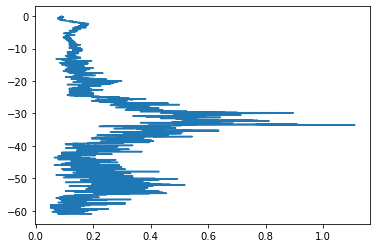

In [9]:
#Threshold for surface and ground
ind =  (df['depth'] < surface) & (df['depth'] > ground)
ind_10cm = (df['depth'] < surface) & (df['depth'] > (surface - 10))
ind_50cm = (df['depth'] < surface) & (df['depth'] > (surface - 50))

# Print out a stat
median = df[ind]['value'].median()
print(median)

sum10 = df[ind_10cm]['value'].sum()
print(sum10)

sum50 =  df[ind_50cm]['value'].sum()
print(sum50)


# plot biz plot the profile vertically.
fig, axes = plt.subplots(1)
axes.plot(df[ind]['value'], df[ind]['depth'])

# fig, axes = plt.subplots(1)
# axes.plot(df[ind_50cm]['value'], df[ind_50cm]['depth'])

# add median force and location to a dataframe
final_df['geom'] = df['geom'].unique() # Which should only be one location
final_df['med_force'] = df[ind]['value'].median()   
final_df['sum10'] = sum10
final_df['sum50'] = sum50
final_df['siteID'] = site
print(final_df)

In [10]:
site = '8C11'

In [11]:

engine_smp, session_smp = get_db(db_name)
q_smp = session_smp.query(LayerData).filter(LayerData.type == 'force').filter(LayerData.site_id.contains(site) )
df_smp = query_to_geopandas(q_smp, engine_smp)

q_pit=session_smp.query(LayerData).filter(LayerData.type == 'hand_hardness').filter(LayerData.site_id.contains(site) )
df_pit = query_to_geopandas(q_pit, engine_smp)

session_smp.close()

# # Plot SMP profile locations with colored by the time they were taken using upside down triangles
# ax = df_smp.plot(column='time', cmap='jet', marker='v', label='SMP', figsize=(5,5), markersize=100, edgecolor='black')

# ax.plot(df_pit.easting, df_pit.northing, color='black', marker='s', markersize=15, label='Pit ({})'.format(site))

# # Add important labels
# ax.set_xlabel('Easting [m]')
# ax.set_ylabel('Northing [m]')
# plt.suptitle('SMP Locations at Site {} Showing Acquisition Order'.format(site), fontsize=16)

# # Avoid using Scientific notation for coords.
# ax.ticklabel_format(style='plain', useOffset=False)
# ax.legend()
# # plt.tight_layout()
# plt.show()

# find closest SMP profile to the pit

# No profile is taken at the same time, so we grab all the unique times and sort them
times = sorted(df_smp['time'].unique())

nprofiles=len(times)

ids=np.empty(nprofiles)

p=0
for t in times:
    ind = df_smp['time'] == t
    data = df_smp.loc[ind].copy()
    ids[p]=data.iloc[0].id
    p+=1
    
i_dists=df_smp['id'].isin(ids)

df_smp_dists=df_smp.loc[i_dists]
df_smp_dists=df_smp_dists.assign(dists=-1)
df_smp_dists['dists']=np.sqrt((df_smp_dists['easting']-df_pit.iloc[0].easting)**2+(df_smp_dists['northing']-df_pit.iloc[0].northing)**2)

    
df_smp_dists.sort_values(by='dists')[['comments','dists']].head() #check out the list of profiles sorted by distance to pit

,comments,dists
8968,"fname = SNEX20_SMP_S19M1158_8C11_20200205.CSV,...",3.400473
0,"fname = SNEX20_SMP_S19M1157_8C11_20200205.CSV,...",5.215657
1868,"fname = SNEX20_SMP_S19M1159_8C11_20200205.CSV,...",5.655628
27,"fname = SNEX20_SMP_S19M1160_8C11_20200205.CSV,...",10.698246
11388,"fname = SNEX20_SMP_S19M1161_8C11_20200205.CSV,...",20.472399


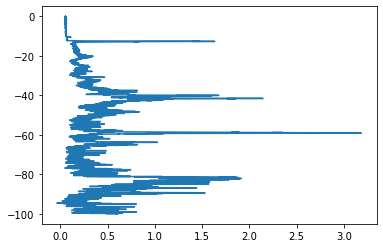

In [12]:
filenames = ['SNEX20_SMP_S19M1158_8C11_20200205.CSV']

for f in filenames:
    # Grab any layer data that has the file name in its comments
    qry = session.query(LayerData).filter(LayerData.comments.contains(f)).order_by('depth')

    # build a geopandas dataframe from the query
    df = query_to_geopandas(qry, engine)

    # Everything in the layers table is a string so we need to cast our value column as a float to calc stats on it
    df['value'] = df['value'].astype(float)

    # plot biz plot the profile vertically.
    fig, axes = plt.subplots(1)
    axes.plot(df['value'], df['depth'])

In [13]:
surface = -10
ground = -105

0.256
45.370999999999995
436.65799999999996
  siteID  med_force                            geom   sum10    sum50
0   8C11      0.256  POINT (741936.919 4326490.807)  45.371  436.658


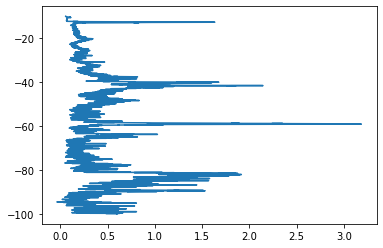

In [14]:
#Threshold for surface and ground
ind =  (df['depth'] < surface) & (df['depth'] > ground)
ind_10cm = (df['depth'] < surface) & (df['depth'] > (surface - 10))
ind_50cm = (df['depth'] < surface) & (df['depth'] > (surface - 50))

# Print out a stat
median = df[ind]['value'].median()
print(median)

sum10 = df[ind_10cm]['value'].sum()
print(sum10)

sum50 =  df[ind_50cm]['value'].sum()
print(sum50)


# plot biz plot the profile vertically.
fig, axes = plt.subplots(1)
axes.plot(df[ind]['value'], df[ind]['depth'])

# fig, axes = plt.subplots(1)
# axes.plot(df[ind_50cm]['value'], df[ind_50cm]['depth'])

# add median force and location to a dataframe
to_add_df['geom'] = df['geom'].unique() # Which should only be one location
to_add_df['med_force'] = df[ind]['value'].median()   
to_add_df['sum10'] = sum10
to_add_df['sum50'] = sum50
to_add_df['siteID'] = site
print(to_add_df)

0.26
998.0989999999999
   med_force                            geom
0       0.26  POINT (742606.052 4322880.455)


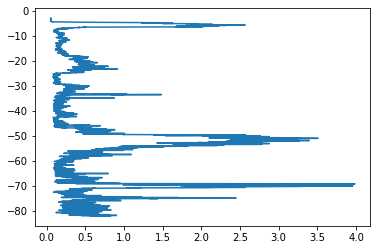

In [14]:
#Threshold for surface and ground
ind =  (df['depth'] < surface) & (df['depth'] > ground)

# Print out a stat
median = df[ind]['value'].median()
sum = df[ind]['value'].sum()
print(median)
print(sum)

# plot biz plot the profile vertically.
fig, axes = plt.subplots(1)
axes.plot(df[ind]['value'], df[ind]['depth'])

# add median force and location to a dataframe
to_add_df['geom'] = df['geom'].unique() # Which should only be one location
to_add_df['med_force'] = median
print(to_add_df)

In [15]:
final_df = final_df.append(to_add_df)
print(final_df)

  siteID  med_force                            geom   sum10    sum50
0   7C15      0.169  POINT (742674.870 4325579.843)  31.749  289.420
0   8C11      0.256  POINT (741936.919 4326490.807)  45.371  436.658


In [16]:
site = '8N38'

In [17]:

engine_smp, session_smp = get_db(db_name)
q_smp = session_smp.query(LayerData).filter(LayerData.type == 'force').filter(LayerData.site_id.contains(site) )
df_smp = query_to_geopandas(q_smp, engine_smp)

q_pit=session_smp.query(LayerData).filter(LayerData.type == 'hand_hardness').filter(LayerData.site_id.contains(site) )
df_pit = query_to_geopandas(q_pit, engine_smp)

session_smp.close()

# # Plot SMP profile locations with colored by the time they were taken using upside down triangles
# ax = df_smp.plot(column='time', cmap='jet', marker='v', label='SMP', figsize=(5,5), markersize=100, edgecolor='black')

# ax.plot(df_pit.easting, df_pit.northing, color='black', marker='s', markersize=15, label='Pit ({})'.format(site))

# # Add important labels
# ax.set_xlabel('Easting [m]')
# ax.set_ylabel('Northing [m]')
# plt.suptitle('SMP Locations at Site {} Showing Acquisition Order'.format(site), fontsize=16)

# # Avoid using Scientific notation for coords.
# ax.ticklabel_format(style='plain', useOffset=False)
# ax.legend()
# # plt.tight_layout()
# plt.show()

# find closest SMP profile to the pit

# No profile is taken at the same time, so we grab all the unique times and sort them
times = sorted(df_smp['time'].unique())

nprofiles=len(times)

ids=np.empty(nprofiles)

p=0
for t in times:
    ind = df_smp['time'] == t
    data = df_smp.loc[ind].copy()
    ids[p]=data.iloc[0].id
    p+=1
    
i_dists=df_smp['id'].isin(ids)

df_smp_dists=df_smp.loc[i_dists]
df_smp_dists=df_smp_dists.assign(dists=-1)
df_smp_dists['dists']=np.sqrt((df_smp_dists['easting']-df_pit.iloc[0].easting)**2+(df_smp_dists['northing']-df_pit.iloc[0].northing)**2)

    
df_smp_dists.sort_values(by='dists')[['comments','dists']].head() #check out the list of profiles sorted by distance to pit

,comments,dists
19747,"fname = SNEX20_SMP_S06M0851_8N38_20200130.CSV,...",2.438944
16674,"fname = SNEX20_SMP_S06M0858_8N38_20200130.CSV,...",2.877528
27508,"fname = SNEX20_SMP_S06M0860_8N38_20200130.CSV,...",2.920150
0,"fname = SNEX20_SMP_S06M0859_8N38_20200130.CSV,...",3.490924
9000,"fname = SNEX20_SMP_S06M0857_8N38_20200130.CSV,...",5.366407


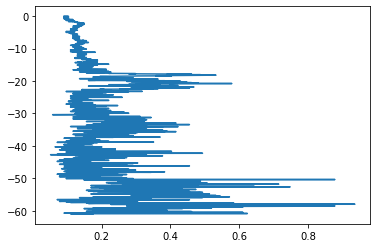

In [18]:
filenames = ['SNEX20_SMP_S06M0851_8N38_20200130.CSV']

for f in filenames:
    # Grab any layer data that has the file name in its comments
    qry = session.query(LayerData).filter(LayerData.comments.contains(f)).order_by('depth')

    # build a geopandas dataframe from the query
    df = query_to_geopandas(qry, engine)

    # Everything in the layers table is a string so we need to cast our value column as a float to calc stats on it
    df['value'] = df['value'].astype(float)

    # plot biz plot the profile vertically.
    fig, axes = plt.subplots(1)
    axes.plot(df['value'], df['depth'])

In [19]:
surface = 0
ground = -65

0.162
30.991
224.32100000000003
  siteID  med_force                            geom   sum10    sum50
0   8N38      0.162  POINT (745305.410 4324000.404)  30.991  224.321


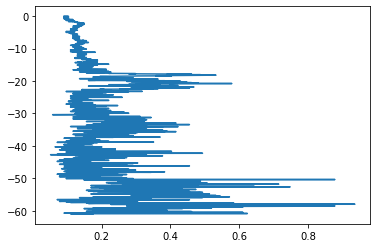

In [20]:
#Threshold for surface and ground
ind =  (df['depth'] < surface) & (df['depth'] > ground)
ind_10cm = (df['depth'] < surface) & (df['depth'] > (surface - 10))
ind_50cm = (df['depth'] < surface) & (df['depth'] > (surface - 50))

# Print out a stat
median = df[ind]['value'].median()
print(median)

sum10 = df[ind_10cm]['value'].sum()
print(sum10)

sum50 =  df[ind_50cm]['value'].sum()
print(sum50)


# plot biz plot the profile vertically.
fig, axes = plt.subplots(1)
axes.plot(df[ind]['value'], df[ind]['depth'])

# fig, axes = plt.subplots(1)
# axes.plot(df[ind_50cm]['value'], df[ind_50cm]['depth'])

# add median force and location to a dataframe
to_add_df['geom'] = df['geom'].unique() # Which should only be one location
to_add_df['med_force'] = df[ind]['value'].median()   
to_add_df['sum10'] = sum10
to_add_df['sum50'] = sum50
to_add_df['siteID'] = site
print(to_add_df)

In [21]:
final_df = final_df.append(to_add_df)
print(final_df)

  siteID  med_force                            geom   sum10    sum50
0   7C15      0.169  POINT (742674.870 4325579.843)  31.749  289.420
0   8C11      0.256  POINT (741936.919 4326490.807)  45.371  436.658
0   8N38      0.162  POINT (745305.410 4324000.404)  30.991  224.321


In [22]:
site = '9C16'

In [23]:

engine_smp, session_smp = get_db(db_name)
q_smp = session_smp.query(LayerData).filter(LayerData.type == 'force').filter(LayerData.site_id.contains(site) )
df_smp = query_to_geopandas(q_smp, engine_smp)

q_pit=session_smp.query(LayerData).filter(LayerData.type == 'hand_hardness').filter(LayerData.site_id.contains(site) )
df_pit = query_to_geopandas(q_pit, engine_smp)

session_smp.close()

# # Plot SMP profile locations with colored by the time they were taken using upside down triangles
# ax = df_smp.plot(column='time', cmap='jet', marker='v', label='SMP', figsize=(5,5), markersize=100, edgecolor='black')

# ax.plot(df_pit.easting, df_pit.northing, color='black', marker='s', markersize=15, label='Pit ({})'.format(site))

# # Add important labels
# ax.set_xlabel('Easting [m]')
# ax.set_ylabel('Northing [m]')
# plt.suptitle('SMP Locations at Site {} Showing Acquisition Order'.format(site), fontsize=16)

# # Avoid using Scientific notation for coords.
# ax.ticklabel_format(style='plain', useOffset=False)
# ax.legend()
# # plt.tight_layout()
# plt.show()

# find closest SMP profile to the pit

# No profile is taken at the same time, so we grab all the unique times and sort them
times = sorted(df_smp['time'].unique())

nprofiles=len(times)

ids=np.empty(nprofiles)

p=0
for t in times:
    ind = df_smp['time'] == t
    data = df_smp.loc[ind].copy()
    ids[p]=data.iloc[0].id
    p+=1
    
i_dists=df_smp['id'].isin(ids)

df_smp_dists=df_smp.loc[i_dists]
df_smp_dists=df_smp_dists.assign(dists=-1)
df_smp_dists['dists']=np.sqrt((df_smp_dists['easting']-df_pit.iloc[0].easting)**2+(df_smp_dists['northing']-df_pit.iloc[0].northing)**2)

    
df_smp_dists.sort_values(by='dists')[['comments','dists']].head() #check out the list of profiles sorted by distance to pit

,comments,dists
37436,"fname = SNEX20_SMP_S19M1152_9C16_20200205.CSV,...",0.775300
26198,"fname = SNEX20_SMP_S19M1134_9C16_20200205.CSV,...",4.395946
14483,"fname = SNEX20_SMP_S19M1150_9C16_20200205.CSV,...",5.511500
44667,"fname = SNEX20_SMP_S19M1151_9C16_20200205.CSV,...",6.743118
31831,"fname = SNEX20_SMP_S19M1145_9C16_20200205.CSV,...",9.301464


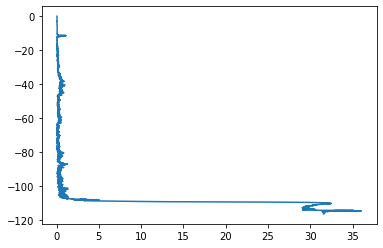

In [24]:
filenames = ['SNEX20_SMP_S19M1152_9C16_20200205.CSV']

for f in filenames:
    # Grab any layer data that has the file name in its comments
    qry = session.query(LayerData).filter(LayerData.comments.contains(f)).order_by('depth')

    # build a geopandas dataframe from the query
    df = query_to_geopandas(qry, engine)

    # Everything in the layers table is a string so we need to cast our value column as a float to calc stats on it
    df['value'] = df['value'].astype(float)

    # plot biz plot the profile vertically.
    fig, axes = plt.subplots(1)
    axes.plot(df['value'], df['depth'])

In [26]:
surface = -10
ground = -105

0.23
28.169000000000004
310.639
  siteID  med_force                            geom   sum10    sum50
0   9C16       0.23  POINT (742580.357 4325429.434)  28.169  310.639


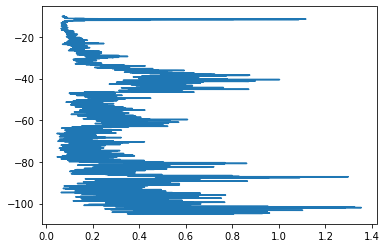

In [27]:
#Threshold for surface and ground
ind =  (df['depth'] < surface) & (df['depth'] > ground)
ind_10cm = (df['depth'] < surface) & (df['depth'] > (surface - 10))
ind_50cm = (df['depth'] < surface) & (df['depth'] > (surface - 50))

# Print out a stat
median = df[ind]['value'].median()
print(median)

sum10 = df[ind_10cm]['value'].sum()
print(sum10)

sum50 =  df[ind_50cm]['value'].sum()
print(sum50)


# plot biz plot the profile vertically.
fig, axes = plt.subplots(1)
axes.plot(df[ind]['value'], df[ind]['depth'])

# fig, axes = plt.subplots(1)
# axes.plot(df[ind_50cm]['value'], df[ind_50cm]['depth'])

# add median force and location to a dataframe
to_add_df['geom'] = df['geom'].unique() # Which should only be one location
to_add_df['med_force'] = df[ind]['value'].median()   
to_add_df['sum10'] = sum10
to_add_df['sum50'] = sum50
to_add_df['siteID'] = site
print(to_add_df)

In [28]:
final_df = final_df.append(to_add_df)
print(final_df)

  siteID  med_force                            geom   sum10    sum50
0   7C15      0.169  POINT (742674.870 4325579.843)  31.749  289.420
0   8C11      0.256  POINT (741936.919 4326490.807)  45.371  436.658
0   8N38      0.162  POINT (745305.410 4324000.404)  30.991  224.321
0   9C16      0.230  POINT (742580.357 4325429.434)  28.169  310.639


In [32]:
site = '9C17'

In [33]:

engine_smp, session_smp = get_db(db_name)
q_smp = session_smp.query(LayerData).filter(LayerData.type == 'force').filter(LayerData.site_id.contains(site) )
df_smp = query_to_geopandas(q_smp, engine_smp)

q_pit=session_smp.query(LayerData).filter(LayerData.type == 'hand_hardness').filter(LayerData.site_id.contains(site) )
df_pit = query_to_geopandas(q_pit, engine_smp)

session_smp.close()

# # Plot SMP profile locations with colored by the time they were taken using upside down triangles
# ax = df_smp.plot(column='time', cmap='jet', marker='v', label='SMP', figsize=(5,5), markersize=100, edgecolor='black')

# ax.plot(df_pit.easting, df_pit.northing, color='black', marker='s', markersize=15, label='Pit ({})'.format(site))

# # Add important labels
# ax.set_xlabel('Easting [m]')
# ax.set_ylabel('Northing [m]')
# plt.suptitle('SMP Locations at Site {} Showing Acquisition Order'.format(site), fontsize=16)

# # Avoid using Scientific notation for coords.
# ax.ticklabel_format(style='plain', useOffset=False)
# ax.legend()
# # plt.tight_layout()
# plt.show()

# find closest SMP profile to the pit

# No profile is taken at the same time, so we grab all the unique times and sort them
times = sorted(df_smp['time'].unique())

nprofiles=len(times)

ids=np.empty(nprofiles)

p=0
for t in times:
    ind = df_smp['time'] == t
    data = df_smp.loc[ind].copy()
    ids[p]=data.iloc[0].id
    p+=1
    
i_dists=df_smp['id'].isin(ids)

df_smp_dists=df_smp.loc[i_dists]
df_smp_dists=df_smp_dists.assign(dists=-1)
df_smp_dists['dists']=np.sqrt((df_smp_dists['easting']-df_pit.iloc[0].easting)**2+(df_smp_dists['northing']-df_pit.iloc[0].northing)**2)

    
df_smp_dists.sort_values(by='dists')[['comments','dists']].head() #check out the list of profiles sorted by distance to pit

,comments,dists
2927,"fname = SNEX20_SMP_S06M0803_9C17_20200130.CSV,...",0.638982
13500,"fname = SNEX20_SMP_S06M0805_9C17_20200130.CSV,...",2.062486
31724,"fname = SNEX20_SMP_S06M0807_9C17_20200130.CSV,...",2.315540
12200,"fname = SNEX20_SMP_S06M0808_9C17_20200130.CSV,...",2.315540
15133,"fname = SNEX20_SMP_S06M0810_9C17_20200130.CSV,...",2.315540


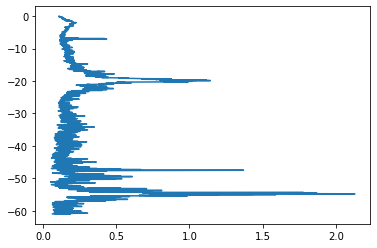

In [34]:
filenames = ['SNEX20_SMP_S06M0803_9C17_20200130.CSV']

for f in filenames:
    # Grab any layer data that has the file name in its comments
    qry = session.query(LayerData).filter(LayerData.comments.contains(f)).order_by('depth')

    # build a geopandas dataframe from the query
    df = query_to_geopandas(qry, engine)

    # Everything in the layers table is a string so we need to cast our value column as a float to calc stats on it
    df['value'] = df['value'].astype(float)

    # plot biz plot the profile vertically.
    fig, axes = plt.subplots(1)
    axes.plot(df['value'], df['depth'])

In [35]:
surface = 0
ground = -65

0.172
39.661
264.485
  siteID  med_force                            geom   sum10    sum50
0   9C17      0.172  POINT (743040.195 4324966.391)  39.661  264.485


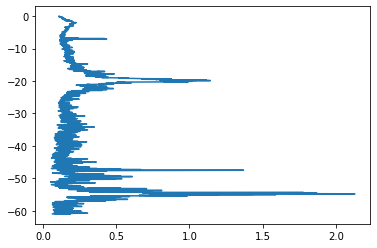

In [36]:
#Threshold for surface and ground
ind =  (df['depth'] < surface) & (df['depth'] > ground)
ind_10cm = (df['depth'] < surface) & (df['depth'] > (surface - 10))
ind_50cm = (df['depth'] < surface) & (df['depth'] > (surface - 50))

# Print out a stat
median = df[ind]['value'].median()
print(median)

sum10 = df[ind_10cm]['value'].sum()
print(sum10)

sum50 =  df[ind_50cm]['value'].sum()
print(sum50)


# plot biz plot the profile vertically.
fig, axes = plt.subplots(1)
axes.plot(df[ind]['value'], df[ind]['depth'])

# fig, axes = plt.subplots(1)
# axes.plot(df[ind_50cm]['value'], df[ind_50cm]['depth'])

# add median force and location to a dataframe
to_add_df['geom'] = df['geom'].unique() # Which should only be one location
to_add_df['med_force'] = df[ind]['value'].median()   
to_add_df['sum10'] = sum10
to_add_df['sum50'] = sum50
to_add_df['siteID'] = site
print(to_add_df)

In [37]:
final_df = final_df.append(to_add_df)
print(final_df)

  siteID  med_force                            geom   sum10    sum50
0   7C15      0.169  POINT (742674.870 4325579.843)  31.749  289.420
0   8C11      0.256  POINT (741936.919 4326490.807)  45.371  436.658
0   8N38      0.162  POINT (745305.410 4324000.404)  30.991  224.321
0   9C16      0.230  POINT (742580.357 4325429.434)  28.169  310.639
0   9C17      0.172  POINT (743040.195 4324966.391)  39.661  264.485


In [38]:
site = '2C12'

In [39]:

engine_smp, session_smp = get_db(db_name)
q_smp = session_smp.query(LayerData).filter(LayerData.type == 'force').filter(LayerData.site_id.contains(site) )
df_smp = query_to_geopandas(q_smp, engine_smp)

q_pit=session_smp.query(LayerData).filter(LayerData.type == 'hand_hardness').filter(LayerData.site_id.contains(site) )
df_pit = query_to_geopandas(q_pit, engine_smp)

session_smp.close()

# # Plot SMP profile locations with colored by the time they were taken using upside down triangles
# ax = df_smp.plot(column='time', cmap='jet', marker='v', label='SMP', figsize=(5,5), markersize=100, edgecolor='black')

# ax.plot(df_pit.easting, df_pit.northing, color='black', marker='s', markersize=15, label='Pit ({})'.format(site))

# # Add important labels
# ax.set_xlabel('Easting [m]')
# ax.set_ylabel('Northing [m]')
# plt.suptitle('SMP Locations at Site {} Showing Acquisition Order'.format(site), fontsize=16)

# # Avoid using Scientific notation for coords.
# ax.ticklabel_format(style='plain', useOffset=False)
# ax.legend()
# # plt.tight_layout()
# plt.show()

# find closest SMP profile to the pit

# No profile is taken at the same time, so we grab all the unique times and sort them
times = sorted(df_smp['time'].unique())

nprofiles=len(times)

ids=np.empty(nprofiles)

p=0
for t in times:
    ind = df_smp['time'] == t
    data = df_smp.loc[ind].copy()
    ids[p]=data.iloc[0].id
    p+=1
    
i_dists=df_smp['id'].isin(ids)

df_smp_dists=df_smp.loc[i_dists]
df_smp_dists=df_smp_dists.assign(dists=-1)
df_smp_dists['dists']=np.sqrt((df_smp_dists['easting']-df_pit.iloc[0].easting)**2+(df_smp_dists['northing']-df_pit.iloc[0].northing)**2)

    
df_smp_dists.sort_values(by='dists')[['comments','dists']].head() #check out the list of profiles sorted by distance to pit

,comments,dists
22761,"fname = SNEX20_SMP_S19M1479_2C12_20200212.CSV,...",1.108941
2191,"fname = SNEX20_SMP_S19M1484_2C12_20200212.CSV,...",14.920851
17437,"fname = SNEX20_SMP_S19M1483_2C12_20200212.CSV,...",23.117949
14533,"fname = SNEX20_SMP_S19M1490_2C12_20200212.CSV,...",26.086094
7031,"fname = SNEX20_SMP_S19M1489_2C12_20200212.CSV,...",29.327493


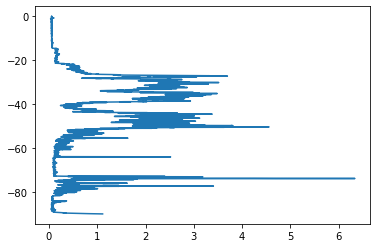

In [40]:
filenames = ['SNEX20_SMP_S19M1479_2C12_20200212.CSV']

for f in filenames:
    # Grab any layer data that has the file name in its comments
    qry = session.query(LayerData).filter(LayerData.comments.contains(f)).order_by('depth')

    # build a geopandas dataframe from the query
    df = query_to_geopandas(qry, engine)

    # Everything in the layers table is a string so we need to cast our value column as a float to calc stats on it
    df['value'] = df['value'].astype(float)

    # plot biz plot the profile vertically.
    fig, axes = plt.subplots(1)
    axes.plot(df['value'], df['depth'])

In [41]:
surface = -15
ground = -90

0.413
66.578
1411.966
  siteID  med_force                            geom   sum10     sum50
0   2C12      0.413  POINT (742228.807 4326412.908)  66.578  1411.966


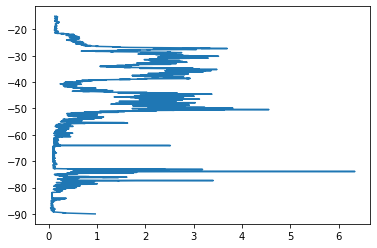

In [42]:
#Threshold for surface and ground
ind =  (df['depth'] < surface) & (df['depth'] > ground)
ind_10cm = (df['depth'] < surface) & (df['depth'] > (surface - 10))
ind_50cm = (df['depth'] < surface) & (df['depth'] > (surface - 50))

# Print out a stat
median = df[ind]['value'].median()
print(median)

sum10 = df[ind_10cm]['value'].sum()
print(sum10)

sum50 =  df[ind_50cm]['value'].sum()
print(sum50)


# plot biz plot the profile vertically.
fig, axes = plt.subplots(1)
axes.plot(df[ind]['value'], df[ind]['depth'])

# fig, axes = plt.subplots(1)
# axes.plot(df[ind_50cm]['value'], df[ind_50cm]['depth'])

# add median force and location to a dataframe
to_add_df['geom'] = df['geom'].unique() # Which should only be one location
to_add_df['med_force'] = df[ind]['value'].median()   
to_add_df['sum10'] = sum10
to_add_df['sum50'] = sum50
to_add_df['siteID'] = site
print(to_add_df)

In [43]:
final_df = final_df.append(to_add_df)
print(final_df)

  siteID  med_force                            geom   sum10     sum50
0   7C15      0.169  POINT (742674.870 4325579.843)  31.749   289.420
0   8C11      0.256  POINT (741936.919 4326490.807)  45.371   436.658
0   8N38      0.162  POINT (745305.410 4324000.404)  30.991   224.321
0   9C16      0.230  POINT (742580.357 4325429.434)  28.169   310.639
0   9C17      0.172  POINT (743040.195 4324966.391)  39.661   264.485
0   2C12      0.413  POINT (742228.807 4326412.908)  66.578  1411.966


In [44]:
site = '5N10'

In [45]:

engine_smp, session_smp = get_db(db_name)
q_smp = session_smp.query(LayerData).filter(LayerData.type == 'force').filter(LayerData.site_id.contains(site) )
df_smp = query_to_geopandas(q_smp, engine_smp)

q_pit=session_smp.query(LayerData).filter(LayerData.type == 'hand_hardness').filter(LayerData.site_id.contains(site) )
df_pit = query_to_geopandas(q_pit, engine_smp)

session_smp.close()

# # Plot SMP profile locations with colored by the time they were taken using upside down triangles
# ax = df_smp.plot(column='time', cmap='jet', marker='v', label='SMP', figsize=(5,5), markersize=100, edgecolor='black')

# ax.plot(df_pit.easting, df_pit.northing, color='black', marker='s', markersize=15, label='Pit ({})'.format(site))

# # Add important labels
# ax.set_xlabel('Easting [m]')
# ax.set_ylabel('Northing [m]')
# plt.suptitle('SMP Locations at Site {} Showing Acquisition Order'.format(site), fontsize=16)

# # Avoid using Scientific notation for coords.
# ax.ticklabel_format(style='plain', useOffset=False)
# ax.legend()
# # plt.tight_layout()
# plt.show()

# find closest SMP profile to the pit

# No profile is taken at the same time, so we grab all the unique times and sort them
times = sorted(df_smp['time'].unique())

nprofiles=len(times)

ids=np.empty(nprofiles)

p=0
for t in times:
    ind = df_smp['time'] == t
    data = df_smp.loc[ind].copy()
    ids[p]=data.iloc[0].id
    p+=1
    
i_dists=df_smp['id'].isin(ids)

df_smp_dists=df_smp.loc[i_dists]
df_smp_dists=df_smp_dists.assign(dists=-1)
df_smp_dists['dists']=np.sqrt((df_smp_dists['easting']-df_pit.iloc[0].easting)**2+(df_smp_dists['northing']-df_pit.iloc[0].northing)**2)

    
df_smp_dists.sort_values(by='dists')[['comments','dists']].head() #check out the list of profiles sorted by distance to pit

,comments,dists
56111,"fname = SNEX20_SMP_S06M0674_5N10_20200128.CSV,...",1.611272
43829,"fname = SNEX20_SMP_S06M0677_5N10_20200128.CSV,...",1.698240
53035,"fname = SNEX20_SMP_S06M0678_5N10_20200128.CSV,...",1.698240
77538,"fname = SNEX20_SMP_S06M0676_5N10_20200128.CSV,...",1.698240
67721,"fname = SNEX20_SMP_S19M1366_5N10_20200210.CSV,...",2.011265


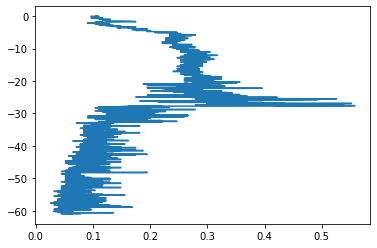

In [46]:
filenames = ['SNEX20_SMP_S06M0674_5N10_20200128.CSV']

for f in filenames:
    # Grab any layer data that has the file name in its comments
    qry = session.query(LayerData).filter(LayerData.comments.contains(f)).order_by('depth')

    # build a geopandas dataframe from the query
    df = query_to_geopandas(qry, engine)

    # Everything in the layers table is a string so we need to cast our value column as a float to calc stats on it
    df['value'] = df['value'].astype(float)

    # plot biz plot the profile vertically.
    fig, axes = plt.subplots(1)
    axes.plot(df['value'], df['depth'])

In [47]:
surface = 0
ground = -65

0.136
49.007999999999996
241.708
  siteID  med_force                            geom   sum10    sum50
0   5N10      0.136  POINT (742378.063 4324185.610)  49.008  241.708


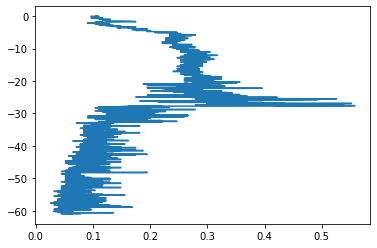

In [48]:
#Threshold for surface and ground
ind =  (df['depth'] < surface) & (df['depth'] > ground)
ind_10cm = (df['depth'] < surface) & (df['depth'] > (surface - 10))
ind_50cm = (df['depth'] < surface) & (df['depth'] > (surface - 50))

# Print out a stat
median = df[ind]['value'].median()
print(median)

sum10 = df[ind_10cm]['value'].sum()
print(sum10)

sum50 =  df[ind_50cm]['value'].sum()
print(sum50)


# plot biz plot the profile vertically.
fig, axes = plt.subplots(1)
axes.plot(df[ind]['value'], df[ind]['depth'])

# fig, axes = plt.subplots(1)
# axes.plot(df[ind_50cm]['value'], df[ind_50cm]['depth'])

# add median force and location to a dataframe
to_add_df['geom'] = df['geom'].unique() # Which should only be one location
to_add_df['med_force'] = df[ind]['value'].median()   
to_add_df['sum10'] = sum10
to_add_df['sum50'] = sum50
to_add_df['siteID'] = site
print(to_add_df)

In [49]:
final_df = final_df.append(to_add_df)
print(final_df)

  siteID  med_force                            geom   sum10     sum50
0   7C15      0.169  POINT (742674.870 4325579.843)  31.749   289.420
0   8C11      0.256  POINT (741936.919 4326490.807)  45.371   436.658
0   8N38      0.162  POINT (745305.410 4324000.404)  30.991   224.321
0   9C16      0.230  POINT (742580.357 4325429.434)  28.169   310.639
0   9C17      0.172  POINT (743040.195 4324966.391)  39.661   264.485
0   2C12      0.413  POINT (742228.807 4326412.908)  66.578  1411.966
0   5N10      0.136  POINT (742378.063 4324185.610)  49.008   241.708


In [50]:
site = '5N19'

In [51]:

engine_smp, session_smp = get_db(db_name)
q_smp = session_smp.query(LayerData).filter(LayerData.type == 'force').filter(LayerData.site_id.contains(site) )
df_smp = query_to_geopandas(q_smp, engine_smp)

q_pit=session_smp.query(LayerData).filter(LayerData.type == 'hand_hardness').filter(LayerData.site_id.contains(site) )
df_pit = query_to_geopandas(q_pit, engine_smp)

session_smp.close()

# # Plot SMP profile locations with colored by the time they were taken using upside down triangles
# ax = df_smp.plot(column='time', cmap='jet', marker='v', label='SMP', figsize=(5,5), markersize=100, edgecolor='black')

# ax.plot(df_pit.easting, df_pit.northing, color='black', marker='s', markersize=15, label='Pit ({})'.format(site))

# # Add important labels
# ax.set_xlabel('Easting [m]')
# ax.set_ylabel('Northing [m]')
# plt.suptitle('SMP Locations at Site {} Showing Acquisition Order'.format(site), fontsize=16)

# # Avoid using Scientific notation for coords.
# ax.ticklabel_format(style='plain', useOffset=False)
# ax.legend()
# # plt.tight_layout()
# plt.show()

# find closest SMP profile to the pit

# No profile is taken at the same time, so we grab all the unique times and sort them
times = sorted(df_smp['time'].unique())

nprofiles=len(times)

ids=np.empty(nprofiles)

p=0
for t in times:
    ind = df_smp['time'] == t
    data = df_smp.loc[ind].copy()
    ids[p]=data.iloc[0].id
    p+=1
    
i_dists=df_smp['id'].isin(ids)

df_smp_dists=df_smp.loc[i_dists]
df_smp_dists=df_smp_dists.assign(dists=-1)
df_smp_dists['dists']=np.sqrt((df_smp_dists['easting']-df_pit.iloc[0].easting)**2+(df_smp_dists['northing']-df_pit.iloc[0].northing)**2)

    
df_smp_dists.sort_values(by='dists')[['comments','dists']].head() #check out the list of profiles sorted by distance to pit

,comments,dists
25858,"fname = SNEX20_SMP_S19M0743_5N19_20200128.CSV,...",5.724373
55066,"fname = SNEX20_SMP_S19M0744_5N19_20200128.CSV,...",5.878827
40779,"fname = SNEX20_SMP_S19M0745_5N19_20200128.CSV,...",5.878827
57731,"fname = SNEX20_SMP_S19M0735_5N19_20200128.CSV,...",7.931272
15517,"fname = SNEX20_SMP_S19M0722_5N19_20200128.CSV,...",8.879409


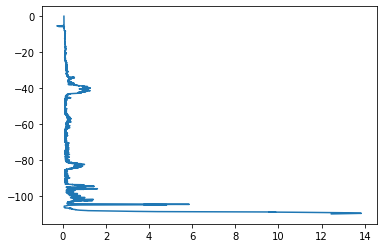

In [52]:
filenames = ['SNEX20_SMP_S19M0743_5N19_20200128.CSV']

for f in filenames:
    # Grab any layer data that has the file name in its comments
    qry = session.query(LayerData).filter(LayerData.comments.contains(f)).order_by('depth')

    # build a geopandas dataframe from the query
    df = query_to_geopandas(qry, engine)

    # Everything in the layers table is a string so we need to cast our value column as a float to calc stats on it
    df['value'] = df['value'].astype(float)

    # plot biz plot the profile vertically.
    fig, axes = plt.subplots(1)
    axes.plot(df['value'], df['depth'])

In [58]:
surface = -10
ground = -100

0.16
25.721000000000004
296.328
  siteID  med_force                            geom   sum10    sum50
0   5N19       0.16  POINT (743220.199 4324254.403)  25.721  296.328


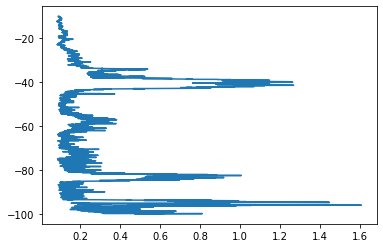

In [59]:
#Threshold for surface and ground
ind =  (df['depth'] < surface) & (df['depth'] > ground)
ind_10cm = (df['depth'] < surface) & (df['depth'] > (surface - 10))
ind_50cm = (df['depth'] < surface) & (df['depth'] > (surface - 50))

# Print out a stat
median = df[ind]['value'].median()
print(median)

sum10 = df[ind_10cm]['value'].sum()
print(sum10)

sum50 =  df[ind_50cm]['value'].sum()
print(sum50)


# plot biz plot the profile vertically.
fig, axes = plt.subplots(1)
axes.plot(df[ind]['value'], df[ind]['depth'])

# fig, axes = plt.subplots(1)
# axes.plot(df[ind_50cm]['value'], df[ind_50cm]['depth'])

# add median force and location to a dataframe
to_add_df['geom'] = df['geom'].unique() # Which should only be one location
to_add_df['med_force'] = df[ind]['value'].median()   
to_add_df['sum10'] = sum10
to_add_df['sum50'] = sum50
to_add_df['siteID'] = site
print(to_add_df)

In [60]:
final_df = final_df.append(to_add_df)
print(final_df)

  siteID  med_force                            geom   sum10     sum50
0   7C15      0.169  POINT (742674.870 4325579.843)  31.749   289.420
0   8C11      0.256  POINT (741936.919 4326490.807)  45.371   436.658
0   8N38      0.162  POINT (745305.410 4324000.404)  30.991   224.321
0   9C16      0.230  POINT (742580.357 4325429.434)  28.169   310.639
0   9C17      0.172  POINT (743040.195 4324966.391)  39.661   264.485
0   2C12      0.413  POINT (742228.807 4326412.908)  66.578  1411.966
0   5N10      0.136  POINT (742378.063 4324185.610)  49.008   241.708
0   5N19      0.160  POINT (743220.199 4324254.403)  25.721   296.328


In [61]:
site = '5S43'

In [62]:

engine_smp, session_smp = get_db(db_name)
q_smp = session_smp.query(LayerData).filter(LayerData.type == 'force').filter(LayerData.site_id.contains(site) )
df_smp = query_to_geopandas(q_smp, engine_smp)

q_pit=session_smp.query(LayerData).filter(LayerData.type == 'hand_hardness').filter(LayerData.site_id.contains(site) )
df_pit = query_to_geopandas(q_pit, engine_smp)

session_smp.close()

# # Plot SMP profile locations with colored by the time they were taken using upside down triangles
# ax = df_smp.plot(column='time', cmap='jet', marker='v', label='SMP', figsize=(5,5), markersize=100, edgecolor='black')

# ax.plot(df_pit.easting, df_pit.northing, color='black', marker='s', markersize=15, label='Pit ({})'.format(site))

# # Add important labels
# ax.set_xlabel('Easting [m]')
# ax.set_ylabel('Northing [m]')
# plt.suptitle('SMP Locations at Site {} Showing Acquisition Order'.format(site), fontsize=16)

# # Avoid using Scientific notation for coords.
# ax.ticklabel_format(style='plain', useOffset=False)
# ax.legend()
# # plt.tight_layout()
# plt.show()

# find closest SMP profile to the pit

# No profile is taken at the same time, so we grab all the unique times and sort them
times = sorted(df_smp['time'].unique())

nprofiles=len(times)

ids=np.empty(nprofiles)

p=0
for t in times:
    ind = df_smp['time'] == t
    data = df_smp.loc[ind].copy()
    ids[p]=data.iloc[0].id
    p+=1
    
i_dists=df_smp['id'].isin(ids)

df_smp_dists=df_smp.loc[i_dists]
df_smp_dists=df_smp_dists.assign(dists=-1)
df_smp_dists['dists']=np.sqrt((df_smp_dists['easting']-df_pit.iloc[0].easting)**2+(df_smp_dists['northing']-df_pit.iloc[0].northing)**2)

    
df_smp_dists.sort_values(by='dists')[['comments','dists']].head() #check out the list of profiles sorted by distance to pit

,comments,dists
1305,"fname = SNEX20_SMP_S06M0711_5S43_20200129.CSV,...",3.386228
16181,"fname = SNEX20_SMP_S06M0729_5S43_20200129.CSV,...",4.038430
22081,"fname = SNEX20_SMP_S06M0730_5S43_20200129.CSV,...",4.171419
25131,"fname = SNEX20_SMP_S06M0728_5S43_20200129.CSV,...",5.219217
17719,"fname = SNEX20_SMP_S06M0710_5S43_20200129.CSV,...",6.655421


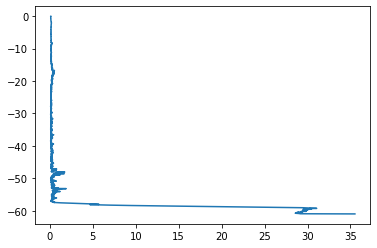

In [63]:
filenames = ['SNEX20_SMP_S06M0711_5S43_20200129.CSV']

for f in filenames:
    # Grab any layer data that has the file name in its comments
    qry = session.query(LayerData).filter(LayerData.comments.contains(f)).order_by('depth')

    # build a geopandas dataframe from the query
    df = query_to_geopandas(qry, engine)

    # Everything in the layers table is a string so we need to cast our value column as a float to calc stats on it
    df['value'] = df['value'].astype(float)

    # plot biz plot the profile vertically.
    fig, axes = plt.subplots(1)
    axes.plot(df['value'], df['depth'])

In [64]:
surface = 0
ground = -56

0.162
34.066
247.123
  siteID  med_force                            geom   sum10    sum50
0   5S43      0.162  POINT (746925.616 4322662.123)  34.066  247.123


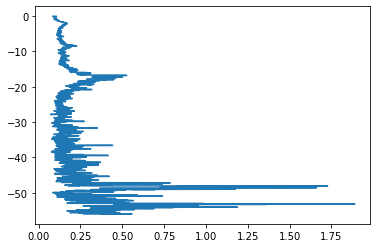

In [65]:
#Threshold for surface and ground
ind =  (df['depth'] < surface) & (df['depth'] > ground)
ind_10cm = (df['depth'] < surface) & (df['depth'] > (surface - 10))
ind_50cm = (df['depth'] < surface) & (df['depth'] > (surface - 50))

# Print out a stat
median = df[ind]['value'].median()
print(median)

sum10 = df[ind_10cm]['value'].sum()
print(sum10)

sum50 =  df[ind_50cm]['value'].sum()
print(sum50)


# plot biz plot the profile vertically.
fig, axes = plt.subplots(1)
axes.plot(df[ind]['value'], df[ind]['depth'])

# fig, axes = plt.subplots(1)
# axes.plot(df[ind_50cm]['value'], df[ind_50cm]['depth'])

# add median force and location to a dataframe
to_add_df['geom'] = df['geom'].unique() # Which should only be one location
to_add_df['med_force'] = df[ind]['value'].median()   
to_add_df['sum10'] = sum10
to_add_df['sum50'] = sum50
to_add_df['siteID'] = site
print(to_add_df)

In [66]:
final_df = final_df.append(to_add_df)
print(final_df)

  siteID  med_force                            geom   sum10     sum50
0   7C15      0.169  POINT (742674.870 4325579.843)  31.749   289.420
0   8C11      0.256  POINT (741936.919 4326490.807)  45.371   436.658
0   8N38      0.162  POINT (745305.410 4324000.404)  30.991   224.321
0   9C16      0.230  POINT (742580.357 4325429.434)  28.169   310.639
0   9C17      0.172  POINT (743040.195 4324966.391)  39.661   264.485
0   2C12      0.413  POINT (742228.807 4326412.908)  66.578  1411.966
0   5N10      0.136  POINT (742378.063 4324185.610)  49.008   241.708
0   5N19      0.160  POINT (743220.199 4324254.403)  25.721   296.328
0   5S43      0.162  POINT (746925.616 4322662.123)  34.066   247.123


In [67]:
site = '8N25'

In [68]:

engine_smp, session_smp = get_db(db_name)
q_smp = session_smp.query(LayerData).filter(LayerData.type == 'force').filter(LayerData.site_id.contains(site) )
df_smp = query_to_geopandas(q_smp, engine_smp)

q_pit=session_smp.query(LayerData).filter(LayerData.type == 'hand_hardness').filter(LayerData.site_id.contains(site) )
df_pit = query_to_geopandas(q_pit, engine_smp)

session_smp.close()

# # Plot SMP profile locations with colored by the time they were taken using upside down triangles
# ax = df_smp.plot(column='time', cmap='jet', marker='v', label='SMP', figsize=(5,5), markersize=100, edgecolor='black')

# ax.plot(df_pit.easting, df_pit.northing, color='black', marker='s', markersize=15, label='Pit ({})'.format(site))

# # Add important labels
# ax.set_xlabel('Easting [m]')
# ax.set_ylabel('Northing [m]')
# plt.suptitle('SMP Locations at Site {} Showing Acquisition Order'.format(site), fontsize=16)

# # Avoid using Scientific notation for coords.
# ax.ticklabel_format(style='plain', useOffset=False)
# ax.legend()
# # plt.tight_layout()
# plt.show()

# find closest SMP profile to the pit

# No profile is taken at the same time, so we grab all the unique times and sort them
times = sorted(df_smp['time'].unique())

nprofiles=len(times)

ids=np.empty(nprofiles)

p=0
for t in times:
    ind = df_smp['time'] == t
    data = df_smp.loc[ind].copy()
    ids[p]=data.iloc[0].id
    p+=1
    
i_dists=df_smp['id'].isin(ids)

df_smp_dists=df_smp.loc[i_dists]
df_smp_dists=df_smp_dists.assign(dists=-1)
df_smp_dists['dists']=np.sqrt((df_smp_dists['easting']-df_pit.iloc[0].easting)**2+(df_smp_dists['northing']-df_pit.iloc[0].northing)**2)

    
df_smp_dists.sort_values(by='dists')[['comments','dists']].head() #check out the list of profiles sorted by distance to pit

,comments,dists
5053,"fname = SNEX20_SMP_S19M0777_8N25_20200128.CSV,...",1.783284
5703,"fname = SNEX20_SMP_S19M0795_8N25_20200128.CSV,...",4.765383
47247,"fname = SNEX20_SMP_S19M0796_8N25_20200128.CSV,...",4.925943
34788,"fname = SNEX20_SMP_S19M0788_8N25_20200128.CSV,...",5.078257
54058,"fname = SNEX20_SMP_S19M0789_8N25_20200128.CSV,...",5.199117


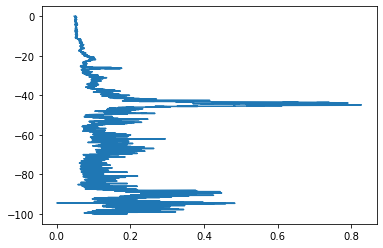

In [69]:
filenames = ['SNEX20_SMP_S19M0777_8N25_20200128.CSV']

for f in filenames:
    # Grab any layer data that has the file name in its comments
    qry = session.query(LayerData).filter(LayerData.comments.contains(f)).order_by('depth')

    # build a geopandas dataframe from the query
    df = query_to_geopandas(qry, engine)

    # Everything in the layers table is a string so we need to cast our value column as a float to calc stats on it
    df['value'] = df['value'].astype(float)

    # plot biz plot the profile vertically.
    fig, axes = plt.subplots(1)
    axes.plot(df['value'], df['depth'])

In [70]:
surface = 0
ground = -102

0.104
12.670000000000005
144.066
  siteID  med_force                            geom  sum10    sum50
0   8N25      0.104  POINT (743617.866 4324414.624)  12.67  144.066


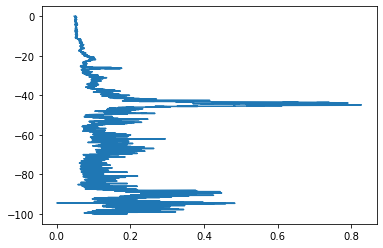

In [71]:
#Threshold for surface and ground
ind =  (df['depth'] < surface) & (df['depth'] > ground)
ind_10cm = (df['depth'] < surface) & (df['depth'] > (surface - 10))
ind_50cm = (df['depth'] < surface) & (df['depth'] > (surface - 50))

# Print out a stat
median = df[ind]['value'].median()
print(median)

sum10 = df[ind_10cm]['value'].sum()
print(sum10)

sum50 =  df[ind_50cm]['value'].sum()
print(sum50)


# plot biz plot the profile vertically.
fig, axes = plt.subplots(1)
axes.plot(df[ind]['value'], df[ind]['depth'])

# fig, axes = plt.subplots(1)
# axes.plot(df[ind_50cm]['value'], df[ind_50cm]['depth'])

# add median force and location to a dataframe
to_add_df['geom'] = df['geom'].unique() # Which should only be one location
to_add_df['med_force'] = df[ind]['value'].median()   
to_add_df['sum10'] = sum10
to_add_df['sum50'] = sum50
to_add_df['siteID'] = site
print(to_add_df)

In [72]:
final_df = final_df.append(to_add_df)
print(final_df)

  siteID  med_force                            geom   sum10     sum50
0   7C15      0.169  POINT (742674.870 4325579.843)  31.749   289.420
0   8C11      0.256  POINT (741936.919 4326490.807)  45.371   436.658
0   8N38      0.162  POINT (745305.410 4324000.404)  30.991   224.321
0   9C16      0.230  POINT (742580.357 4325429.434)  28.169   310.639
0   9C17      0.172  POINT (743040.195 4324966.391)  39.661   264.485
0   2C12      0.413  POINT (742228.807 4326412.908)  66.578  1411.966
0   5N10      0.136  POINT (742378.063 4324185.610)  49.008   241.708
0   5N19      0.160  POINT (743220.199 4324254.403)  25.721   296.328
0   5S43      0.162  POINT (746925.616 4322662.123)  34.066   247.123
0   8N25      0.104  POINT (743617.866 4324414.624)  12.670   144.066


In [73]:
site = '9S51'

In [74]:

engine_smp, session_smp = get_db(db_name)
q_smp = session_smp.query(LayerData).filter(LayerData.type == 'force').filter(LayerData.site_id.contains(site) )
df_smp = query_to_geopandas(q_smp, engine_smp)

q_pit=session_smp.query(LayerData).filter(LayerData.type == 'hand_hardness').filter(LayerData.site_id.contains(site) )
df_pit = query_to_geopandas(q_pit, engine_smp)

session_smp.close()

# # Plot SMP profile locations with colored by the time they were taken using upside down triangles
# ax = df_smp.plot(column='time', cmap='jet', marker='v', label='SMP', figsize=(5,5), markersize=100, edgecolor='black')

# ax.plot(df_pit.easting, df_pit.northing, color='black', marker='s', markersize=15, label='Pit ({})'.format(site))

# # Add important labels
# ax.set_xlabel('Easting [m]')
# ax.set_ylabel('Northing [m]')
# plt.suptitle('SMP Locations at Site {} Showing Acquisition Order'.format(site), fontsize=16)

# # Avoid using Scientific notation for coords.
# ax.ticklabel_format(style='plain', useOffset=False)
# ax.legend()
# # plt.tight_layout()
# plt.show()

# find closest SMP profile to the pit

# No profile is taken at the same time, so we grab all the unique times and sort them
times = sorted(df_smp['time'].unique())

nprofiles=len(times)

ids=np.empty(nprofiles)

p=0
for t in times:
    ind = df_smp['time'] == t
    data = df_smp.loc[ind].copy()
    ids[p]=data.iloc[0].id
    p+=1
    
i_dists=df_smp['id'].isin(ids)

df_smp_dists=df_smp.loc[i_dists]
df_smp_dists=df_smp_dists.assign(dists=-1)
df_smp_dists['dists']=np.sqrt((df_smp_dists['easting']-df_pit.iloc[0].easting)**2+(df_smp_dists['northing']-df_pit.iloc[0].northing)**2)

    
df_smp_dists.sort_values(by='dists')[['comments','dists']].head() #check out the list of profiles sorted by distance to pit

,comments,dists
25580,"fname = SNEX20_SMP_S06M0778_9S51_20200129.CSV,...",3.401423
7073,"fname = SNEX20_SMP_S06M0776_9S51_20200129.CSV,...",4.837354
1113,"fname = SNEX20_SMP_S06M0773_9S51_20200129.CSV,...",5.428927
2676,"fname = SNEX20_SMP_S06M0770_9S51_20200129.CSV,...",9.332031
27049,"fname = SNEX20_SMP_S06M0777_9S51_20200129.CSV,...",9.684893


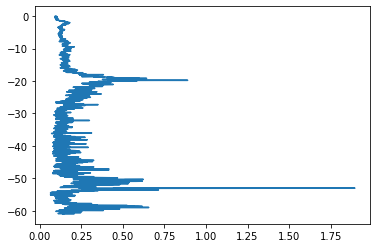

In [75]:
filenames = ['SNEX20_SMP_S06M0778_9S51_20200129.CSV']

for f in filenames:
    # Grab any layer data that has the file name in its comments
    qry = session.query(LayerData).filter(LayerData.comments.contains(f)).order_by('depth')

    # build a geopandas dataframe from the query
    df = query_to_geopandas(qry, engine)

    # Everything in the layers table is a string so we need to cast our value column as a float to calc stats on it
    df['value'] = df['value'].astype(float)

    # plot biz plot the profile vertically.
    fig, axes = plt.subplots(1)
    axes.plot(df['value'], df['depth'])

In [76]:
surface = 0
ground = -65

0.156
34.023
220.24
  siteID  med_force                            geom   sum10   sum50
0   9S51      0.156  POINT (748320.515 4322634.367)  34.023  220.24


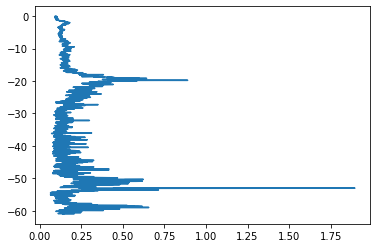

In [77]:
#Threshold for surface and ground
ind =  (df['depth'] < surface) & (df['depth'] > ground)
ind_10cm = (df['depth'] < surface) & (df['depth'] > (surface - 10))
ind_50cm = (df['depth'] < surface) & (df['depth'] > (surface - 50))

# Print out a stat
median = df[ind]['value'].median()
print(median)

sum10 = df[ind_10cm]['value'].sum()
print(sum10)

sum50 =  df[ind_50cm]['value'].sum()
print(sum50)


# plot biz plot the profile vertically.
fig, axes = plt.subplots(1)
axes.plot(df[ind]['value'], df[ind]['depth'])

# fig, axes = plt.subplots(1)
# axes.plot(df[ind_50cm]['value'], df[ind_50cm]['depth'])

# add median force and location to a dataframe
to_add_df['geom'] = df['geom'].unique() # Which should only be one location
to_add_df['med_force'] = df[ind]['value'].median()   
to_add_df['sum10'] = sum10
to_add_df['sum50'] = sum50
to_add_df['siteID'] = site
print(to_add_df)

In [78]:
final_df = final_df.append(to_add_df)
print(final_df)

  siteID  med_force                            geom   sum10     sum50
0   7C15      0.169  POINT (742674.870 4325579.843)  31.749   289.420
0   8C11      0.256  POINT (741936.919 4326490.807)  45.371   436.658
0   8N38      0.162  POINT (745305.410 4324000.404)  30.991   224.321
0   9C16      0.230  POINT (742580.357 4325429.434)  28.169   310.639
0   9C17      0.172  POINT (743040.195 4324966.391)  39.661   264.485
0   2C12      0.413  POINT (742228.807 4326412.908)  66.578  1411.966
0   5N10      0.136  POINT (742378.063 4324185.610)  49.008   241.708
0   5N19      0.160  POINT (743220.199 4324254.403)  25.721   296.328
0   5S43      0.162  POINT (746925.616 4322662.123)  34.066   247.123
0   8N25      0.104  POINT (743617.866 4324414.624)  12.670   144.066
0   9S51      0.156  POINT (748320.515 4322634.367)  34.023   220.240


In [79]:
site = '1N23'

In [80]:

engine_smp, session_smp = get_db(db_name)
q_smp = session_smp.query(LayerData).filter(LayerData.type == 'force').filter(LayerData.site_id.contains(site) )
df_smp = query_to_geopandas(q_smp, engine_smp)

q_pit=session_smp.query(LayerData).filter(LayerData.type == 'hand_hardness').filter(LayerData.site_id.contains(site) )
df_pit = query_to_geopandas(q_pit, engine_smp)

session_smp.close()

# # Plot SMP profile locations with colored by the time they were taken using upside down triangles
# ax = df_smp.plot(column='time', cmap='jet', marker='v', label='SMP', figsize=(5,5), markersize=100, edgecolor='black')

# ax.plot(df_pit.easting, df_pit.northing, color='black', marker='s', markersize=15, label='Pit ({})'.format(site))

# # Add important labels
# ax.set_xlabel('Easting [m]')
# ax.set_ylabel('Northing [m]')
# plt.suptitle('SMP Locations at Site {} Showing Acquisition Order'.format(site), fontsize=16)

# # Avoid using Scientific notation for coords.
# ax.ticklabel_format(style='plain', useOffset=False)
# ax.legend()
# # plt.tight_layout()
# plt.show()

# find closest SMP profile to the pit

# No profile is taken at the same time, so we grab all the unique times and sort them
times = sorted(df_smp['time'].unique())

nprofiles=len(times)

ids=np.empty(nprofiles)

p=0
for t in times:
    ind = df_smp['time'] == t
    data = df_smp.loc[ind].copy()
    ids[p]=data.iloc[0].id
    p+=1
    
i_dists=df_smp['id'].isin(ids)

df_smp_dists=df_smp.loc[i_dists]
df_smp_dists=df_smp_dists.assign(dists=-1)
df_smp_dists['dists']=np.sqrt((df_smp_dists['easting']-df_pit.iloc[0].easting)**2+(df_smp_dists['northing']-df_pit.iloc[0].northing)**2)

    
df_smp_dists.sort_values(by='dists')[['comments','dists']].head() #check out the list of profiles sorted by distance to pit

,comments,dists
0,"fname = SNEX20_SMP_S19M1477_1N23_20200211.CSV,...",2.533204
1605,"fname = SNEX20_SMP_S19M1478_1N23_20200211.CSV,...",2.742104
3495,"fname = SNEX20_SMP_S19M1476_1N23_20200211.CSV,...",4.147655


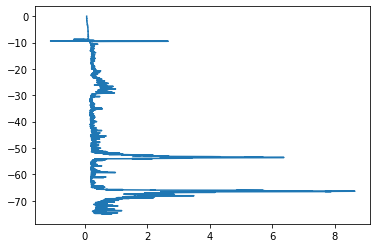

In [81]:
filenames = ['SNEX20_SMP_S19M1477_1N23_20200211.CSV']

for f in filenames:
    # Grab any layer data that has the file name in its comments
    qry = session.query(LayerData).filter(LayerData.comments.contains(f)).order_by('depth')

    # build a geopandas dataframe from the query
    df = query_to_geopandas(qry, engine)

    # Everything in the layers table is a string so we need to cast our value column as a float to calc stats on it
    df['value'] = df['value'].astype(float)

    # plot biz plot the profile vertically.
    fig, axes = plt.subplots(1)
    axes.plot(df['value'], df['depth'])

In [82]:
surface = -10
ground = -80

0.275
58.165
479.286
  siteID  med_force                            geom   sum10    sum50
0   1N23      0.275  POINT (743549.053 4324074.696)  58.165  479.286


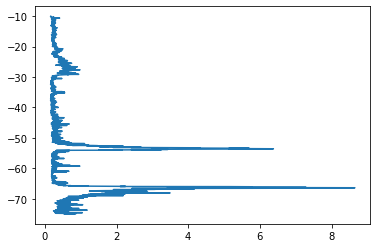

In [83]:
#Threshold for surface and ground
ind =  (df['depth'] < surface) & (df['depth'] > ground)
ind_10cm = (df['depth'] < surface) & (df['depth'] > (surface - 10))
ind_50cm = (df['depth'] < surface) & (df['depth'] > (surface - 50))

# Print out a stat
median = df[ind]['value'].median()
print(median)

sum10 = df[ind_10cm]['value'].sum()
print(sum10)

sum50 =  df[ind_50cm]['value'].sum()
print(sum50)


# plot biz plot the profile vertically.
fig, axes = plt.subplots(1)
axes.plot(df[ind]['value'], df[ind]['depth'])

# fig, axes = plt.subplots(1)
# axes.plot(df[ind_50cm]['value'], df[ind_50cm]['depth'])

# add median force and location to a dataframe
to_add_df['geom'] = df['geom'].unique() # Which should only be one location
to_add_df['med_force'] = df[ind]['value'].median()   
to_add_df['sum10'] = sum10
to_add_df['sum50'] = sum50
to_add_df['siteID'] = site
print(to_add_df)

In [84]:
final_df = final_df.append(to_add_df)
print(final_df)

  siteID  med_force                            geom   sum10     sum50
0   7C15      0.169  POINT (742674.870 4325579.843)  31.749   289.420
0   8C11      0.256  POINT (741936.919 4326490.807)  45.371   436.658
0   8N38      0.162  POINT (745305.410 4324000.404)  30.991   224.321
0   9C16      0.230  POINT (742580.357 4325429.434)  28.169   310.639
0   9C17      0.172  POINT (743040.195 4324966.391)  39.661   264.485
0   2C12      0.413  POINT (742228.807 4326412.908)  66.578  1411.966
0   5N10      0.136  POINT (742378.063 4324185.610)  49.008   241.708
0   5N19      0.160  POINT (743220.199 4324254.403)  25.721   296.328
0   5S43      0.162  POINT (746925.616 4322662.123)  34.066   247.123
0   8N25      0.104  POINT (743617.866 4324414.624)  12.670   144.066
0   9S51      0.156  POINT (748320.515 4322634.367)  34.023   220.240
0   1N23      0.275  POINT (743549.053 4324074.696)  58.165   479.286


In [85]:
site = '1S8'

In [86]:

engine_smp, session_smp = get_db(db_name)
q_smp = session_smp.query(LayerData).filter(LayerData.type == 'force').filter(LayerData.site_id.contains(site) )
df_smp = query_to_geopandas(q_smp, engine_smp)

q_pit=session_smp.query(LayerData).filter(LayerData.type == 'hand_hardness').filter(LayerData.site_id.contains(site) )
df_pit = query_to_geopandas(q_pit, engine_smp)

session_smp.close()

# # Plot SMP profile locations with colored by the time they were taken using upside down triangles
# ax = df_smp.plot(column='time', cmap='jet', marker='v', label='SMP', figsize=(5,5), markersize=100, edgecolor='black')

# ax.plot(df_pit.easting, df_pit.northing, color='black', marker='s', markersize=15, label='Pit ({})'.format(site))

# # Add important labels
# ax.set_xlabel('Easting [m]')
# ax.set_ylabel('Northing [m]')
# plt.suptitle('SMP Locations at Site {} Showing Acquisition Order'.format(site), fontsize=16)

# # Avoid using Scientific notation for coords.
# ax.ticklabel_format(style='plain', useOffset=False)
# ax.legend()
# # plt.tight_layout()
# plt.show()

# find closest SMP profile to the pit

# No profile is taken at the same time, so we grab all the unique times and sort them
times = sorted(df_smp['time'].unique())

nprofiles=len(times)

ids=np.empty(nprofiles)

p=0
for t in times:
    ind = df_smp['time'] == t
    data = df_smp.loc[ind].copy()
    ids[p]=data.iloc[0].id
    p+=1
    
i_dists=df_smp['id'].isin(ids)

df_smp_dists=df_smp.loc[i_dists]
df_smp_dists=df_smp_dists.assign(dists=-1)
df_smp_dists['dists']=np.sqrt((df_smp_dists['easting']-df_pit.iloc[0].easting)**2+(df_smp_dists['northing']-df_pit.iloc[0].northing)**2)

    
df_smp_dists.sort_values(by='dists')[['comments','dists']].head() #check out the list of profiles sorted by distance to pit

,comments,dists
13415,"fname = SNEX20_SMP_S19M0939_1S8_20200201.CSV, ...",1.724743
68247,"fname = SNEX20_SMP_S19M0940_1S8_20200201.CSV, ...",3.274884
20147,"fname = SNEX20_SMP_S19M0941_1S8_20200201.CSV, ...",3.602398
70312,"fname = SNEX20_SMP_S19M0938_1S8_20200201.CSV, ...",3.862510
18022,"fname = SNEX20_SMP_S19M0937_1S8_20200201.CSV, ...",3.862510


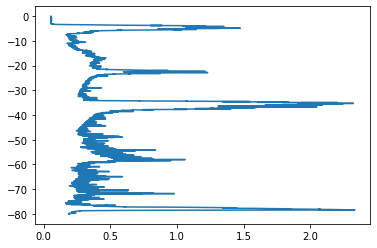

In [87]:
filenames = ['SNEX20_SMP_S19M0939_1S8_20200201.CSV']

for f in filenames:
    # Grab any layer data that has the file name in its comments
    qry = session.query(LayerData).filter(LayerData.comments.contains(f)).order_by('depth')

    # build a geopandas dataframe from the query
    df = query_to_geopandas(qry, engine)

    # Everything in the layers table is a string so we need to cast our value column as a float to calc stats on it
    df['value'] = df['value'].astype(float)

    # plot biz plot the profile vertically.
    fig, axes = plt.subplots(1)
    axes.plot(df['value'], df['depth'])

In [90]:
surface = -3
ground = -83

0.34
99.42500000000001
568.171
  siteID  med_force                            geom   sum10    sum50
0    1S8       0.34  POINT (742607.520 4322918.645)  99.425  568.171


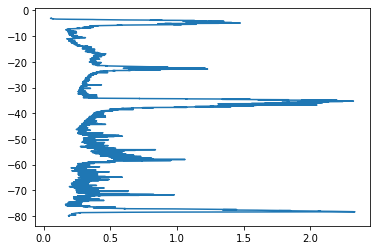

In [91]:
#Threshold for surface and ground
ind =  (df['depth'] < surface) & (df['depth'] > ground)
ind_10cm = (df['depth'] < surface) & (df['depth'] > (surface - 10))
ind_50cm = (df['depth'] < surface) & (df['depth'] > (surface - 50))

# Print out a stat
median = df[ind]['value'].median()
print(median)

sum10 = df[ind_10cm]['value'].sum()
print(sum10)

sum50 =  df[ind_50cm]['value'].sum()
print(sum50)


# plot biz plot the profile vertically.
fig, axes = plt.subplots(1)
axes.plot(df[ind]['value'], df[ind]['depth'])

# fig, axes = plt.subplots(1)
# axes.plot(df[ind_50cm]['value'], df[ind_50cm]['depth'])

# add median force and location to a dataframe
to_add_df['geom'] = df['geom'].unique() # Which should only be one location
to_add_df['med_force'] = df[ind]['value'].median()   
to_add_df['sum10'] = sum10
to_add_df['sum50'] = sum50
to_add_df['siteID'] = site
print(to_add_df)

In [92]:
final_df = final_df.append(to_add_df)
print(final_df)

  siteID  med_force                            geom   sum10     sum50
0   7C15      0.169  POINT (742674.870 4325579.843)  31.749   289.420
0   8C11      0.256  POINT (741936.919 4326490.807)  45.371   436.658
0   8N38      0.162  POINT (745305.410 4324000.404)  30.991   224.321
0   9C16      0.230  POINT (742580.357 4325429.434)  28.169   310.639
0   9C17      0.172  POINT (743040.195 4324966.391)  39.661   264.485
0   2C12      0.413  POINT (742228.807 4326412.908)  66.578  1411.966
0   5N10      0.136  POINT (742378.063 4324185.610)  49.008   241.708
0   5N19      0.160  POINT (743220.199 4324254.403)  25.721   296.328
0   5S43      0.162  POINT (746925.616 4322662.123)  34.066   247.123
0   8N25      0.104  POINT (743617.866 4324414.624)  12.670   144.066
0   9S51      0.156  POINT (748320.515 4322634.367)  34.023   220.240
0   1N23      0.275  POINT (743549.053 4324074.696)  58.165   479.286
0    1S8      0.340  POINT (742607.520 4322918.645)  99.425   568.171


In [93]:
site = '2S11'

In [94]:

engine_smp, session_smp = get_db(db_name)
q_smp = session_smp.query(LayerData).filter(LayerData.type == 'force').filter(LayerData.site_id.contains(site) )
df_smp = query_to_geopandas(q_smp, engine_smp)

q_pit=session_smp.query(LayerData).filter(LayerData.type == 'hand_hardness').filter(LayerData.site_id.contains(site) )
df_pit = query_to_geopandas(q_pit, engine_smp)

session_smp.close()

# # Plot SMP profile locations with colored by the time they were taken using upside down triangles
# ax = df_smp.plot(column='time', cmap='jet', marker='v', label='SMP', figsize=(5,5), markersize=100, edgecolor='black')

# ax.plot(df_pit.easting, df_pit.northing, color='black', marker='s', markersize=15, label='Pit ({})'.format(site))

# # Add important labels
# ax.set_xlabel('Easting [m]')
# ax.set_ylabel('Northing [m]')
# plt.suptitle('SMP Locations at Site {} Showing Acquisition Order'.format(site), fontsize=16)

# # Avoid using Scientific notation for coords.
# ax.ticklabel_format(style='plain', useOffset=False)
# ax.legend()
# # plt.tight_layout()
# plt.show()

# find closest SMP profile to the pit

# No profile is taken at the same time, so we grab all the unique times and sort them
times = sorted(df_smp['time'].unique())

nprofiles=len(times)

ids=np.empty(nprofiles)

p=0
for t in times:
    ind = df_smp['time'] == t
    data = df_smp.loc[ind].copy()
    ids[p]=data.iloc[0].id
    p+=1
    
i_dists=df_smp['id'].isin(ids)

df_smp_dists=df_smp.loc[i_dists]
df_smp_dists=df_smp_dists.assign(dists=-1)
df_smp_dists['dists']=np.sqrt((df_smp_dists['easting']-df_pit.iloc[0].easting)**2+(df_smp_dists['northing']-df_pit.iloc[0].northing)**2)

    
df_smp_dists.sort_values(by='dists')[['comments','dists']].head() #check out the list of profiles sorted by distance to pit

,comments,dists
30677,"fname = SNEX20_SMP_S19M0972_2S11_20200201.CSV,...",4.151605
45461,"fname = SNEX20_SMP_S19M0971_2S11_20200201.CSV,...",4.171270
0,"fname = SNEX20_SMP_S19M0970_2S11_20200201.CSV,...",4.799736
7412,"fname = SNEX20_SMP_S19M0963_2S11_20200201.CSV,...",5.104695
47931,"fname = SNEX20_SMP_S19M0955_2S11_20200201.CSV,...",10.846425


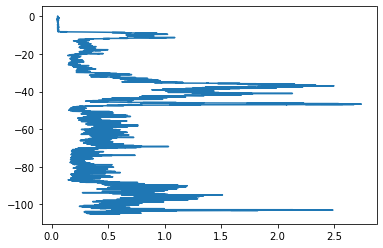

In [95]:
filenames = ['SNEX20_SMP_S19M0972_2S11_20200201.CSV']

for f in filenames:
    # Grab any layer data that has the file name in its comments
    qry = session.query(LayerData).filter(LayerData.comments.contains(f)).order_by('depth')

    # build a geopandas dataframe from the query
    df = query_to_geopandas(qry, engine)

    # Everything in the layers table is a string so we need to cast our value column as a float to calc stats on it
    df['value'] = df['value'].astype(float)

    # plot biz plot the profile vertically.
    fig, axes = plt.subplots(1)
    axes.plot(df['value'], df['depth'])

In [96]:
surface = -7
ground = -110

0.415
104.46600000000001
730.356
  siteID  med_force                            geom    sum10    sum50
0   2S11      0.415  POINT (743112.602 4322921.936)  104.466  730.356


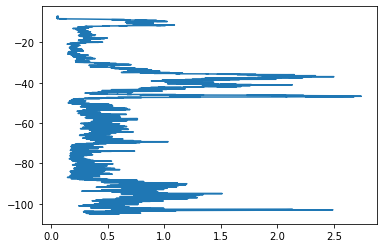

In [97]:
#Threshold for surface and ground
ind =  (df['depth'] < surface) & (df['depth'] > ground)
ind_10cm = (df['depth'] < surface) & (df['depth'] > (surface - 10))
ind_50cm = (df['depth'] < surface) & (df['depth'] > (surface - 50))

# Print out a stat
median = df[ind]['value'].median()
print(median)

sum10 = df[ind_10cm]['value'].sum()
print(sum10)

sum50 =  df[ind_50cm]['value'].sum()
print(sum50)


# plot biz plot the profile vertically.
fig, axes = plt.subplots(1)
axes.plot(df[ind]['value'], df[ind]['depth'])

# fig, axes = plt.subplots(1)
# axes.plot(df[ind_50cm]['value'], df[ind_50cm]['depth'])

# add median force and location to a dataframe
to_add_df['geom'] = df['geom'].unique() # Which should only be one location
to_add_df['med_force'] = df[ind]['value'].median()   
to_add_df['sum10'] = sum10
to_add_df['sum50'] = sum50
to_add_df['siteID'] = site
print(to_add_df)

In [98]:
final_df = final_df.append(to_add_df)
print(final_df)

  siteID  med_force                            geom    sum10     sum50
0   7C15      0.169  POINT (742674.870 4325579.843)   31.749   289.420
0   8C11      0.256  POINT (741936.919 4326490.807)   45.371   436.658
0   8N38      0.162  POINT (745305.410 4324000.404)   30.991   224.321
0   9C16      0.230  POINT (742580.357 4325429.434)   28.169   310.639
0   9C17      0.172  POINT (743040.195 4324966.391)   39.661   264.485
0   2C12      0.413  POINT (742228.807 4326412.908)   66.578  1411.966
0   5N10      0.136  POINT (742378.063 4324185.610)   49.008   241.708
0   5N19      0.160  POINT (743220.199 4324254.403)   25.721   296.328
0   5S43      0.162  POINT (746925.616 4322662.123)   34.066   247.123
0   8N25      0.104  POINT (743617.866 4324414.624)   12.670   144.066
0   9S51      0.156  POINT (748320.515 4322634.367)   34.023   220.240
0   1N23      0.275  POINT (743549.053 4324074.696)   58.165   479.286
0    1S8      0.340  POINT (742607.520 4322918.645)   99.425   568.171
0   2S

In [99]:
site = '5N11'

In [100]:

engine_smp, session_smp = get_db(db_name)
q_smp = session_smp.query(LayerData).filter(LayerData.type == 'force').filter(LayerData.site_id.contains(site) )
df_smp = query_to_geopandas(q_smp, engine_smp)

q_pit=session_smp.query(LayerData).filter(LayerData.type == 'hand_hardness').filter(LayerData.site_id.contains(site) )
df_pit = query_to_geopandas(q_pit, engine_smp)

session_smp.close()

# # Plot SMP profile locations with colored by the time they were taken using upside down triangles
# ax = df_smp.plot(column='time', cmap='jet', marker='v', label='SMP', figsize=(5,5), markersize=100, edgecolor='black')

# ax.plot(df_pit.easting, df_pit.northing, color='black', marker='s', markersize=15, label='Pit ({})'.format(site))

# # Add important labels
# ax.set_xlabel('Easting [m]')
# ax.set_ylabel('Northing [m]')
# plt.suptitle('SMP Locations at Site {} Showing Acquisition Order'.format(site), fontsize=16)

# # Avoid using Scientific notation for coords.
# ax.ticklabel_format(style='plain', useOffset=False)
# ax.legend()
# # plt.tight_layout()
# plt.show()

# find closest SMP profile to the pit

# No profile is taken at the same time, so we grab all the unique times and sort them
times = sorted(df_smp['time'].unique())

nprofiles=len(times)

ids=np.empty(nprofiles)

p=0
for t in times:
    ind = df_smp['time'] == t
    data = df_smp.loc[ind].copy()
    ids[p]=data.iloc[0].id
    p+=1
    
i_dists=df_smp['id'].isin(ids)

df_smp_dists=df_smp.loc[i_dists]
df_smp_dists=df_smp_dists.assign(dists=-1)
df_smp_dists['dists']=np.sqrt((df_smp_dists['easting']-df_pit.iloc[0].easting)**2+(df_smp_dists['northing']-df_pit.iloc[0].northing)**2)

    
df_smp_dists.sort_values(by='dists')[['comments','dists']].head() #check out the list of profiles sorted by distance to pit

,comments,dists
53026,"fname = SNEX20_SMP_S19M1384_5N11_20200210.CSV,...",3.253967
17006,"fname = SNEX20_SMP_S19M1383_5N11_20200210.CSV,...",4.602821
34312,"fname = SNEX20_SMP_S19M1381_5N11_20200210.CSV,...",6.048940
7500,"fname = SNEX20_SMP_S19M1382_5N11_20200210.CSV,...",6.294330
38789,"fname = SNEX20_SMP_S19M1386_5N11_20200210.CSV,...",6.528159


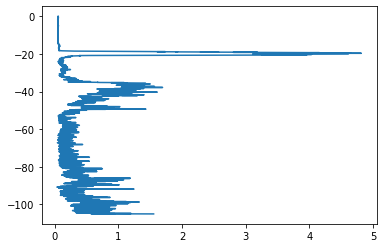

In [101]:
filenames = ['SNEX20_SMP_S19M1384_5N11_20200210.CSV']

for f in filenames:
    # Grab any layer data that has the file name in its comments
    qry = session.query(LayerData).filter(LayerData.comments.contains(f)).order_by('depth')

    # build a geopandas dataframe from the query
    df = query_to_geopandas(qry, engine)

    # Everything in the layers table is a string so we need to cast our value column as a float to calc stats on it
    df['value'] = df['value'].astype(float)

    # plot biz plot the profile vertically.
    fig, axes = plt.subplots(1)
    axes.plot(df['value'], df['depth'])

In [102]:
surface = -17
ground = -120

0.238
196.34100000000004
589.2139999999999
  siteID  med_force                            geom    sum10    sum50
0   5N11      0.238  POINT (742374.751 4324464.813)  196.341  589.214


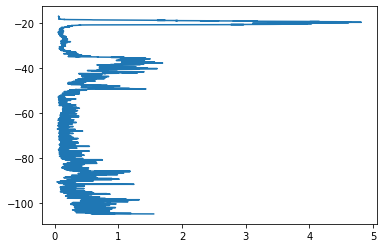

In [103]:
#Threshold for surface and ground
ind =  (df['depth'] < surface) & (df['depth'] > ground)
ind_10cm = (df['depth'] < surface) & (df['depth'] > (surface - 10))
ind_50cm = (df['depth'] < surface) & (df['depth'] > (surface - 50))

# Print out a stat
median = df[ind]['value'].median()
print(median)

sum10 = df[ind_10cm]['value'].sum()
print(sum10)

sum50 =  df[ind_50cm]['value'].sum()
print(sum50)


# plot biz plot the profile vertically.
fig, axes = plt.subplots(1)
axes.plot(df[ind]['value'], df[ind]['depth'])

# fig, axes = plt.subplots(1)
# axes.plot(df[ind_50cm]['value'], df[ind_50cm]['depth'])

# add median force and location to a dataframe
to_add_df['geom'] = df['geom'].unique() # Which should only be one location
to_add_df['med_force'] = df[ind]['value'].median()   
to_add_df['sum10'] = sum10
to_add_df['sum50'] = sum50
to_add_df['siteID'] = site
print(to_add_df)

In [104]:
final_df = final_df.append(to_add_df)
print(final_df)

  siteID  med_force                            geom    sum10     sum50
0   7C15      0.169  POINT (742674.870 4325579.843)   31.749   289.420
0   8C11      0.256  POINT (741936.919 4326490.807)   45.371   436.658
0   8N38      0.162  POINT (745305.410 4324000.404)   30.991   224.321
0   9C16      0.230  POINT (742580.357 4325429.434)   28.169   310.639
0   9C17      0.172  POINT (743040.195 4324966.391)   39.661   264.485
0   2C12      0.413  POINT (742228.807 4326412.908)   66.578  1411.966
0   5N10      0.136  POINT (742378.063 4324185.610)   49.008   241.708
0   5N19      0.160  POINT (743220.199 4324254.403)   25.721   296.328
0   5S43      0.162  POINT (746925.616 4322662.123)   34.066   247.123
0   8N25      0.104  POINT (743617.866 4324414.624)   12.670   144.066
0   9S51      0.156  POINT (748320.515 4322634.367)   34.023   220.240
0   1N23      0.275  POINT (743549.053 4324074.696)   58.165   479.286
0    1S8      0.340  POINT (742607.520 4322918.645)   99.425   568.171
0   2S

In [105]:
site = '5N15'

In [106]:

engine_smp, session_smp = get_db(db_name)
q_smp = session_smp.query(LayerData).filter(LayerData.type == 'force').filter(LayerData.site_id.contains(site) )
df_smp = query_to_geopandas(q_smp, engine_smp)

q_pit=session_smp.query(LayerData).filter(LayerData.type == 'hand_hardness').filter(LayerData.site_id.contains(site) )
df_pit = query_to_geopandas(q_pit, engine_smp)

session_smp.close()

# # Plot SMP profile locations with colored by the time they were taken using upside down triangles
# ax = df_smp.plot(column='time', cmap='jet', marker='v', label='SMP', figsize=(5,5), markersize=100, edgecolor='black')

# ax.plot(df_pit.easting, df_pit.northing, color='black', marker='s', markersize=15, label='Pit ({})'.format(site))

# # Add important labels
# ax.set_xlabel('Easting [m]')
# ax.set_ylabel('Northing [m]')
# plt.suptitle('SMP Locations at Site {} Showing Acquisition Order'.format(site), fontsize=16)

# # Avoid using Scientific notation for coords.
# ax.ticklabel_format(style='plain', useOffset=False)
# ax.legend()
# # plt.tight_layout()
# plt.show()

# find closest SMP profile to the pit

# No profile is taken at the same time, so we grab all the unique times and sort them
times = sorted(df_smp['time'].unique())

nprofiles=len(times)

ids=np.empty(nprofiles)

p=0
for t in times:
    ind = df_smp['time'] == t
    data = df_smp.loc[ind].copy()
    ids[p]=data.iloc[0].id
    p+=1
    
i_dists=df_smp['id'].isin(ids)

df_smp_dists=df_smp.loc[i_dists]
df_smp_dists=df_smp_dists.assign(dists=-1)
df_smp_dists['dists']=np.sqrt((df_smp_dists['easting']-df_pit.iloc[0].easting)**2+(df_smp_dists['northing']-df_pit.iloc[0].northing)**2)

    
df_smp_dists.sort_values(by='dists')[['comments','dists']].head() #check out the list of profiles sorted by distance to pit

,comments,dists
29170,"fname = SNEX20_SMP_S19M1188_5N15_20200206.CSV,...",1.448648
37511,"fname = SNEX20_SMP_S19M1196_5N15_20200206.CSV,...",1.978863
49314,"fname = SNEX20_SMP_S19M1190_5N15_20200206.CSV,...",2.667578
0,"fname = SNEX20_SMP_S19M1189_5N15_20200206.CSV,...",3.799602
43291,"fname = SNEX20_SMP_S19M1195_5N15_20200206.CSV,...",9.212671


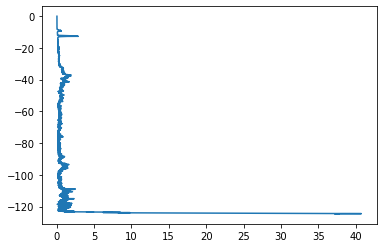

In [107]:
filenames = ['SNEX20_SMP_S19M1188_5N15_20200206.CSV']

for f in filenames:
    # Grab any layer data that has the file name in its comments
    qry = session.query(LayerData).filter(LayerData.comments.contains(f)).order_by('depth')

    # build a geopandas dataframe from the query
    df = query_to_geopandas(qry, engine)

    # Everything in the layers table is a string so we need to cast our value column as a float to calc stats on it
    df['value'] = df['value'].astype(float)

    # plot biz plot the profile vertically.
    fig, axes = plt.subplots(1)
    axes.plot(df['value'], df['depth'])

In [110]:
surface = -7
ground = -122

0.404
73.187
635.241
  siteID  med_force                            geom   sum10    sum50
0   5N15      0.404  POINT (743057.553 4324276.078)  73.187  635.241


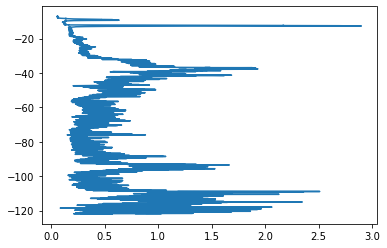

In [111]:
#Threshold for surface and ground
ind =  (df['depth'] < surface) & (df['depth'] > ground)
ind_10cm = (df['depth'] < surface) & (df['depth'] > (surface - 10))
ind_50cm = (df['depth'] < surface) & (df['depth'] > (surface - 50))

# Print out a stat
median = df[ind]['value'].median()
print(median)

sum10 = df[ind_10cm]['value'].sum()
print(sum10)

sum50 =  df[ind_50cm]['value'].sum()
print(sum50)


# plot biz plot the profile vertically.
fig, axes = plt.subplots(1)
axes.plot(df[ind]['value'], df[ind]['depth'])

# fig, axes = plt.subplots(1)
# axes.plot(df[ind_50cm]['value'], df[ind_50cm]['depth'])

# add median force and location to a dataframe
to_add_df['geom'] = df['geom'].unique() # Which should only be one location
to_add_df['med_force'] = df[ind]['value'].median()   
to_add_df['sum10'] = sum10
to_add_df['sum50'] = sum50
to_add_df['siteID'] = site
print(to_add_df)

In [112]:
final_df = final_df.append(to_add_df)
print(final_df)

  siteID  med_force                            geom    sum10     sum50
0   7C15      0.169  POINT (742674.870 4325579.843)   31.749   289.420
0   8C11      0.256  POINT (741936.919 4326490.807)   45.371   436.658
0   8N38      0.162  POINT (745305.410 4324000.404)   30.991   224.321
0   9C16      0.230  POINT (742580.357 4325429.434)   28.169   310.639
0   9C17      0.172  POINT (743040.195 4324966.391)   39.661   264.485
0   2C12      0.413  POINT (742228.807 4326412.908)   66.578  1411.966
0   5N10      0.136  POINT (742378.063 4324185.610)   49.008   241.708
0   5N19      0.160  POINT (743220.199 4324254.403)   25.721   296.328
0   5S43      0.162  POINT (746925.616 4322662.123)   34.066   247.123
0   8N25      0.104  POINT (743617.866 4324414.624)   12.670   144.066
0   9S51      0.156  POINT (748320.515 4322634.367)   34.023   220.240
0   1N23      0.275  POINT (743549.053 4324074.696)   58.165   479.286
0    1S8      0.340  POINT (742607.520 4322918.645)   99.425   568.171
0   2S

In [113]:
len(final_df)

16

In [117]:
final_df.to_csv('SMP_data.csv')